In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import lax
import argparse
import sys
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import pickle

# Add the path to the directory containing the file
sys.path.append(os.path.abspath('../benchmarking/'))
from utils import *


## Load in data

In [2]:
data = "/cluster/tufts/pettilab/shared/structure_comparison_data"
pairs_path = f"{data}/train_test_val/pairs_validation.csv"
coord_path = f"{data}/alphabets_blosum_coordinates/allCACoord.npz"

In [3]:
coord_d = np.load(coord_path)
# how long is each protein
name_to_length_d ={}
for key in coord_d.keys():
    name_to_length_d[key]= coord_d[key].shape[0]

In [4]:
# remove anything with 'd1e25a_' since we seem to be having some length issues
# remove any pairs with length > 512 

pairs = []
alns_as_lists = []
first = True
with open(pairs_path, mode='r') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        pair = (row[1],row[2])
        if first:
            first = False
            continue    
        elif pair[0] == 'd1e25a_' or  pair[1]=='d1e25a_':
            continue
        elif name_to_length_d[pair[0]]>512 or name_to_length_d[pair[1]]>512:
            continue
        else:
            pairs.append(pair)
            alns_as_lists.append([int(i) for i in row[-1].strip('[]').split()])

print(len(pairs))

2828


## Compute counts of Jaccard scores

In [5]:
def aln_list_to_tensor(l1, l2, aln_list):
    tensor = jnp.zeros(shape= (l1,l2))
    pairs = [(index, value) for index, value in enumerate(aln_list) if value != -1]
    indices = jnp.array([i for i, _ in pairs])
    values = jnp.array([j for _, j in pairs])
    tensor = tensor.at[indices, values].set(1)
    return tensor

In [6]:
nhot_d = pickle.load(open(f'{data}/allProtSphericalBinsWithSecondaryStruct_1Hot.pkl','rb'))
transition_mtx = np.loadtxt(f'{data}/transitionMtx.txt',delimiter = ',')

In [7]:
%%time
aln_tensors = []
for i, pair in enumerate(pairs):
    aln_tensors.append(aln_list_to_tensor(name_to_length_d[pair[0]],name_to_length_d[pair[1]], alns_as_lists[i]))

CPU times: user 53.4 s, sys: 16.2 s, total: 1min 9s
Wall time: 3min 6s


In [8]:
%%time
# construct list of jaccard sim matrices
sim_tensors = []
for i, pair in enumerate(pairs):
    sim_tensors.append(sim_mtx_blurry(nhot_d[pair[0]], nhot_d[pair[1]], transition_mtx))

CPU times: user 2min 53s, sys: 36 s, total: 3min 29s
Wall time: 7min 41s


In [9]:
jaccards = []
aln_pos = []
for i in range(len(pairs)):
    jaccards+=list(sim_tensors[i].flatten())
    aln_pos+=list(aln_tensors[i].flatten())

In [10]:
# number of aligned positions
p = sum(aln_pos)/len(aln_pos)
print(p)

0.0027728565211500374


In [11]:
# jaccards at the aligned positions
aln_jaccards = [jaccards[i] for i in range(len(jaccards)) if aln_pos[i]==1]

In [12]:
print(sum(aln_pos),len(aln_jaccards)) #should be equal

615961.0 615961


In [13]:
sum(aln_pos)==len(aln_jaccards) #should be true

True

In [20]:
def create_count_list(values, lb=0, ub=1, num_bins=100):
    # Create 100 bins between 0 and 1 (or as specified by num_bins)
    bin_edges = list(np.linspace(lb, ub, num_bins + 1))
    #bin_edges = [0]+list(np.linspace(lb, ub, num_bins + 1))+[1.0]  # 101 bin edges for 100 bins
    print(bin_edges)
    # Compute the histogram
    counts, _ = np.histogram(values, bins=bin_edges)   
    return counts

In [24]:
nbins =100
aln_counts = create_count_list(aln_jaccards, 0, 1)
total_counts = create_count_list(jaccards)

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35000000000000003, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41000000000000003, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47000000000000003, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.5700000000000001, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.6900000000000001, 0.7000000000000001, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.8200000000000001, 0.8300000000000001, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0.9500000000000001, 0.96, 0.97, 0.98, 0.99, 1.0]
[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35000000000000003, 0.36, 0.37, 0.38, 0.39, 0.4, 0.4

In [25]:
total_counts.shape

(100,)

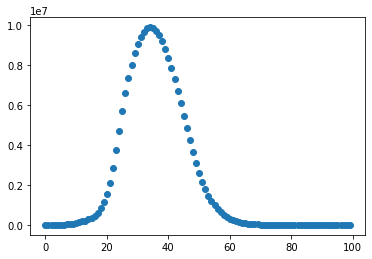

In [26]:
plt.scatter(range(nbins), total_counts)

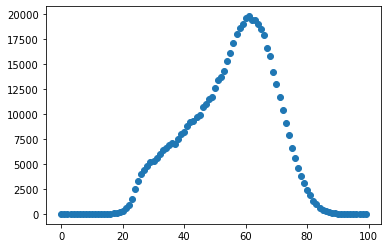

In [27]:
plt.scatter(range(nbins), aln_counts)

<ipython-input-28-ede5cf930259>:1: RuntimeWarning: invalid value encountered in long_scalars
  plt.scatter(range(nbins), [aln_counts[i]/total_counts[i] for i in range(nbins)])


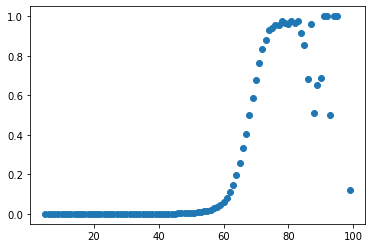

In [28]:
plt.scatter(range(nbins), [aln_counts[i]/total_counts[i] for i in range(nbins)])

<ipython-input-29-9e306506c4cf>:1: RuntimeWarning: invalid value encountered in long_scalars
  plt.scatter(range(nbins), [aln_counts[i]/total_counts[i] for i in range(nbins)])


(0.0, 0.01)

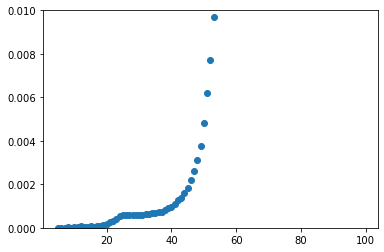

In [29]:
plt.scatter(range(nbins), [aln_counts[i]/total_counts[i] for i in range(nbins)])
plt.ylim(0,.01)

## Make BLOSUM matrix

In [30]:
blosum = []
for i in range(nbins):
    blosum.append(2* (jnp.log(aln_counts[i]/total_counts[i])-jnp.log(p)).item())

<ipython-input-30-17f8ff386431>:3: RuntimeWarning: invalid value encountered in long_scalars
  blosum.append(2* (jnp.log(aln_counts[i]/total_counts[i])-jnp.log(p)).item())


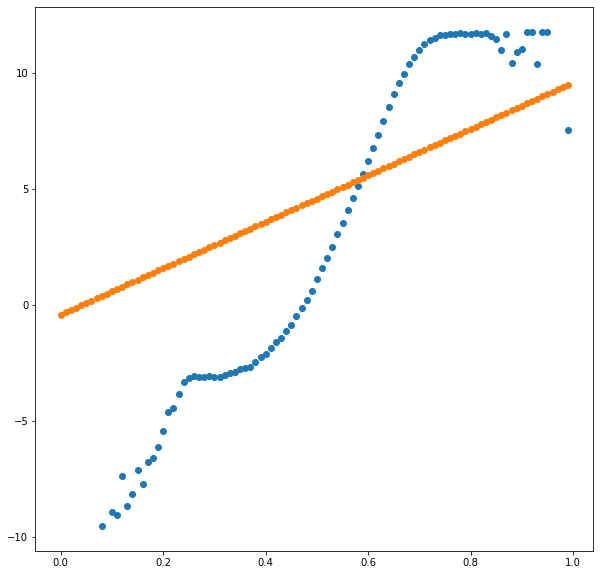

In [31]:
# comparison to linear scheme
plt.figure(figsize = (10,10))
plt.scatter([i/nbins for i in range(nbins)], blosum)
plt.scatter([i/nbins for i in range(nbins)], [i/10-.4 for i in range(nbins)])

In [32]:
# manual interpolation since we probably have some low count issues
blosum_new = np.zeros(100)
# no data here; set to lowest value
for i in range(8):
    blosum_new[i] = blosum[8]
# linearly interpolate in the noisy zone
diff = blosum[25]-blosum[8]
for i in range(8,25):
    blosum_new[i]= (i-8)/(25-8)*diff + blosum[8]
# keep middle the same
for i in range(25,100-20):
    blosum_new[i]= blosum[i]
# make values >.8 all equal to the highest score
for i in range(100-20,100):
    blosum_new[i] = blosum[100-9]


In [41]:
blosum_int = np.round(blosum_new).astype(int)

In [42]:
blosum_int

array([-10, -10, -10, -10, -10, -10, -10, -10, -10,  -9,  -9,  -8,  -8,
        -8,  -7,  -7,  -6,  -6,  -6,  -5,  -5,  -5,  -4,  -4,  -3,  -3,
        -3,  -3,  -3,  -3,  -3,  -3,  -3,  -3,  -3,  -3,  -3,  -3,  -2,
        -2,  -2,  -2,  -2,  -1,  -1,  -1,   0,   0,   0,   1,   1,   2,
         2,   3,   3,   4,   4,   5,   5,   6,   6,   7,   7,   8,   9,
         9,  10,  10,  10,  11,  11,  11,  11,  12,  12,  12,  12,  12,
        12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,
        12,  12,  12,  12,  12,  12,  12,  12,  12])

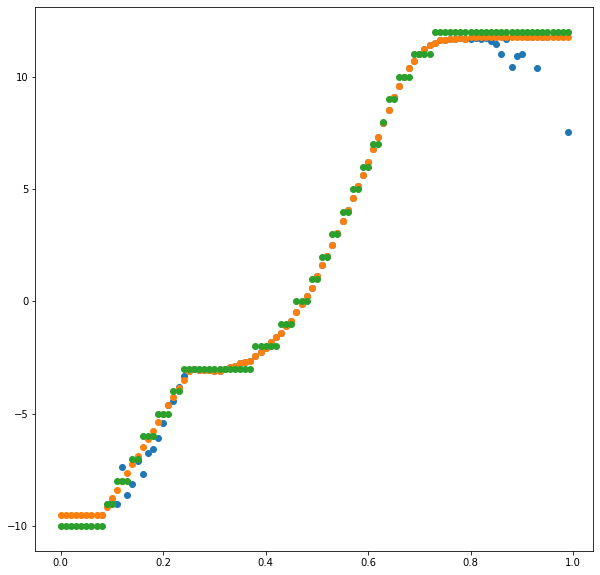

In [43]:
plt.figure(figsize = (10,10))
plt.scatter([i/nbins for i in range(nbins)], blosum)
plt.scatter([i/nbins for i in range(nbins)], blosum_new)
plt.scatter([i/nbins for i in range(nbins)], blosum_int)

In [45]:
#np.save('jaccard_blosum.npy', blosum_new)
np.save(f"{data}/alphabets_blosum_coordinates/jaccard_blosum_int.npy", blosum_int)

## compute lambda and k

In [50]:
from compute_lambda_and_k import *

In [52]:
probs_of_each_bin = total_counts/sum(total_counts)
low = np.min(blosum_int)
high = np.max(blosum_int)
probs = np.zeros(high-low +1)
for i in range(blosum_int.shape[0]):   
    probs[blosum_int[i]-low] += probs_of_each_bin[i]
       
lam, k = call_karlin(low, high, probs)
print(lam,k)

0.48811590671539307 0.19362170684809096


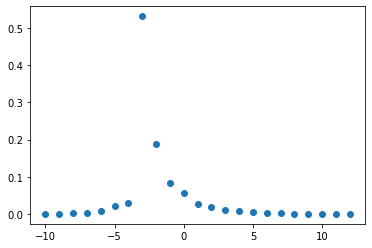

In [57]:
plt.scatter(range(low,high+1), probs)

In [ ]:
#call_karlin(low, high, pr_array)